In [84]:
# !pip install pyvinecopulib
# !pip install scikit-gstat


In [85]:
#!pip install pykrige


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import skgstat as skg
import pykrige
from functions.helper import *
                                                                        


In [31]:
# load in data (same as in spcopula demo)

# options for variables: zinc, copper, lead, and cadmium
variable = 'zinc'

src = skg.data.meuse(variable=variable)

coords, vals = src.get('sample')

# make a dataframe
df = pd.DataFrame(
    {'x': coords[:, 0], 'y': coords[:, 1], variable: vals.flatten()})

df.head()


,x,y,zinc
0,181072,333611,1022
1,181025,333558,1141
2,181165,333537,640
3,181298,333484,257
4,181307,333330,269


In [32]:
# df = pd.read_csv('sic2004data_01\sic2004_01.csv', names=['x', 'y', 'radiation'])
# variable = 'radiation'


# df_test = pd.read_csv('sic2004data_01\\1st_file_true_values.csv',
#                       names=['x', 'y', 'radiation'])
# variable = 'radiation'


# df


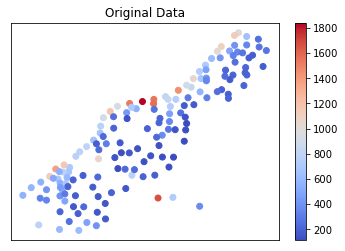

In [33]:
# create a scatter plot of the zinc value in the coordinatess
plt.scatter(df["x"], df["y"], c=df[variable], cmap=plt.cm.coolwarm)
# get current axes
ax = plt.gca()

plt.xlabel("x")
plt.ylabel("y")
plt.title("Original Data")
# hide x-axis
ax.get_xaxis().set_visible(False)

# hide y-axis
ax.get_yaxis().set_visible(False)

plt.colorbar()
plt.show()


In [34]:
# initialize the DataSet class with df and variable
dataset = DataSet(df, variable_of_interest=variable)

In [35]:
# add the rank column to the original dataframe
dataset.add_rank()
dataset.df

,x,y,zinc,rank
0,181072,333611,1022,0.897436
1,181025,333558,1141,0.935897
2,181165,333537,640,0.724359
3,181298,333484,257,0.423077
4,181307,333330,269,0.448718
...,...,...,...,...
150,179184,330182,166,0.144231
151,179085,330292,496,0.628205
152,178875,330311,342,0.512821
153,179466,330381,162,0.134615


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 117293.52965175122
Full Sill: 136404.36432412427
Range: 537.7342715712551
Nugget: 19110.83467237304 



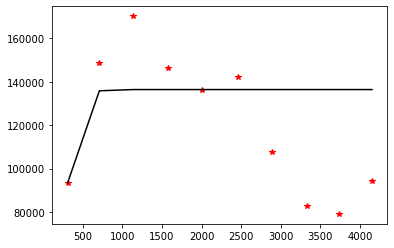

Calculating statistics on variogram model fit...


In [82]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

df
x = df['x'].values
y = df['y'].values
phi = df[variable].values

OK = OrdinaryKriging(
    x,
    y,
    phi,
    variogram_model='gaussian',
    verbose=True,
    enable_plotting=True,
    nlags=10,
)


In [83]:
gridx = np.arange(x.min(), x.max(), 10, dtype='float64')
gridy = np.arange(y.min(), y.max(), 10, dtype='float64')
zstar, ss = OK.execute("grid", gridx, gridy)

print(zstar.shape)
print(ss.shape)


Executing Ordinary Kriging...

(390, 279)
(390, 279)


Text(0.5, 1.0, 'Porosity estimate')

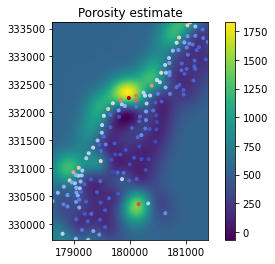

In [84]:
cax = plt.imshow(zstar, extent=(x.min(), x.max(),
                 y.min(), y.max(),), origin='lower')
plt.scatter(x, y, c=phi, marker='.', cmap=plt.cm.coolwarm)
cbar=plt.colorbar(cax)
plt.title('Porosity estimate')

# cax = plt.imshow(np.sqrt(ss),  extent=(x.min(), x.max(),
#                  y.min(), y.max(),),
#                  origin='lower', vmin=0)
# plt.scatter(x, y, c=phi, marker='.')
# cbar = plt.colorbar(cax)
# plt.title('Porosity standard devation')


In [85]:
zstar.shape

(390, 279)

In [94]:
rankx = df.rank()["x"]
rankx = rankx/(len(rankx)+1)*390
ranky = df.rank()["y"]
ranky = ranky/(len(ranky)+1)*279




In [95]:
ranky = ranky.round(0).astype(int)
rankx = rankx.round(0).astype(int)

In [98]:
result_list = []
for x,y in zip(rankx,ranky):
    result_list.append(zstar[x,y])

In [100]:
df.zinc

0      1022
1      1141
2       640
3       257
4       269
       ... 
150     166
151     496
152     342
153     162
154     375
Name: zinc, Length: 155, dtype: int64

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 85557.21506199578
Full Sill: 123975.79163040318
Range: 63.44502058615336
Nugget: 38418.5765684074 



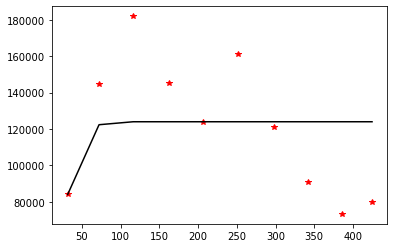

Calculating statistics on variogram model fit...


In [86]:

x=rankx
y=ranky
phi = df.zinc.values

OK = OrdinaryKriging(
    x,
    y,
    phi,
    variogram_model='gaussian',
    verbose=True,
    enable_plotting=True,
    nlags=10,
)






In [72]:
gridx = np.arange(x.min(), x.max(), 100, dtype='float64')
gridy = np.arange(y.min(), y.max(), 100, dtype='float64')
zstar, ss = OK.execute("grid", gridx, gridy)
print(zstar.shape)
print(ss.shape)


Executing Ordinary Kriging...

(10, 10)
(10, 10)


Text(0.5, 1.0, 'Porosity estimate')

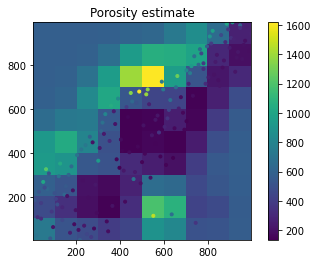

In [74]:

cax = plt.imshow(zstar, extent=(x.min(), x.max(),
                 y.min(), y.max(),), origin='lower')
plt.scatter(x, y, c=phi, marker='.')
cbar = plt.colorbar(cax)
plt.title('Porosity estimate')

In [112]:
# construct the pairs for the whole dataset (without the cutoff value)
dataset.construct_pairs()

# cutoff value for the distance matrix
cutoff_value = 800

# convert the dataframe in pairs of stations (using the cutoff value)
dataset.apply_cutoff(cutoff_value)

#prints first 5 rows of the pairs of stations dataframe
dataset.all_pairs.head()


23870it [00:01, 15180.90it/s]


,index1,index2,rank1,rank2,distance
0,0,1,0.961538,0.903846,70.837843
1,0,2,0.961538,0.814103,118.848643
2,0,3,0.961538,0.589744,259.239272
3,0,4,0.961538,0.637821,366.314073
4,0,5,0.961538,0.669872,473.629602


In [113]:
# build the neighbourhoods (sorted by distance) and store them in a list
neigh_size = 5
dataset.build_neighbourhoods(neigh_size)


100%|██████████| 155/155 [00:00<00:00, 910.25it/s]


In [114]:
# calculate bins for the pairs of stations
num_bins = 10

# initiate the spatial copula with dataset, number of bins and cutoff value
spatial_copula = SpatialCopula(dataset, dataset.neighbourhoods, num_bins, cutoff_value)

# calculate the bins
spatial_copula.calculate_bins()

#prints the list of bin means

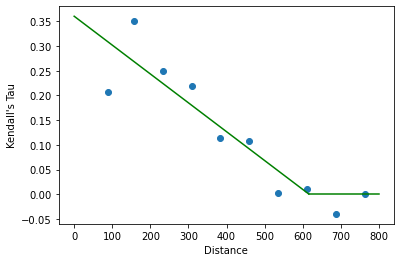

In [115]:
# calculate kendalls tau per bin
spatial_copula.calculate_kendall()

# fit the model for kendall's tau and bins
spatial_copula.fit_model_kendall()

# plot the model
spatial_copula.plot_kendall()



In [116]:
# convert the bins to copulas
spatial_copula.calculate_copulas()

print(spatial_copula.copulas)


[<pyvinecopulib.Bicop>
Joe, parameters = 1.80473, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.3665, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.28811, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.21996, <pyvinecopulib.Bicop>
Joe 180°, parameters = 1.27839, <pyvinecopulib.Bicop>
Joe 180°, parameters = 1.1785, <pyvinecopulib.Bicop>
Independence, <pyvinecopulib.Bicop>
Independence, <pyvinecopulib.Bicop>
Independence]


In [117]:
# now we need to predict the mean with the expectation
# with the list_neighbourhood_ln as neighs
# df as our data train
# df as our data test
# super_cops for the copulas

dataset.construct_pairs_lognorm()

# here we choose the number of neighbours we want for prediction
dataset.build_neighbourhoods_ln(neighbourhood_size=neigh_size)

23870it [00:01, 16622.15it/s]
100%|██████████| 155/155 [00:00<00:00, 882.53it/s]


In [118]:
# testing kriging


In [124]:
# num_bins_list = [spatial_copula.num_bins, 10, 10, 10, 10, 10, 10, 10, 10, 10,
#                       10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8]

num_bins_list = [spatial_copula.num_bins] + [8]*3 + [6]*1 + [1]*10

cutoff_list = [spatial_copula.cutoff_value] + [600]*20 + [600]*1 + [400]*10


In [125]:
num_copulas = 5

spatial_vine_copula = SpatialVineCoupla(
    first_spatial_copula=spatial_copula, dataset=dataset,
    num_copulas=num_copulas, num_bins_list=num_bins_list, cutoff_list=cutoff_list)


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


In [126]:
spatial_vine_copula.calculate_predictions()
spatial_vine_copula.get_results()

100%|██████████| 155/155 [00:02<00:00, 70.55it/s]

Number of errors: 0
Median Absolute Error: 1.0680761398792442
Mean Absolute Error: 1.8243263654582231
Bias: 0.004681121884927802
Root Mean Squared Error: 2.75532608669746


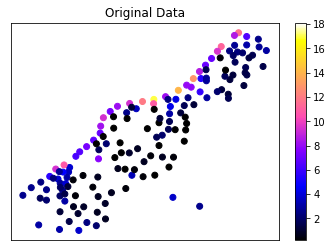

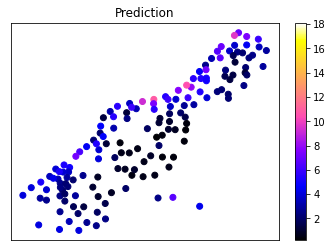

In [127]:
spatial_vine_copula.plot_original_data()
spatial_vine_copula.plot_predicted_data()

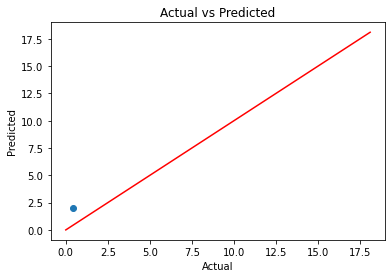

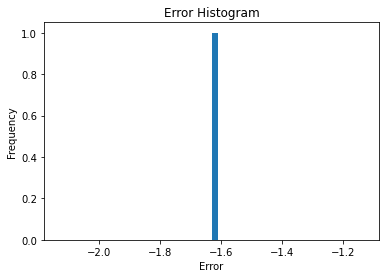

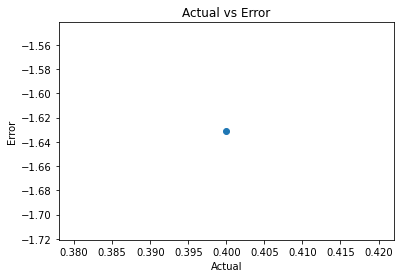

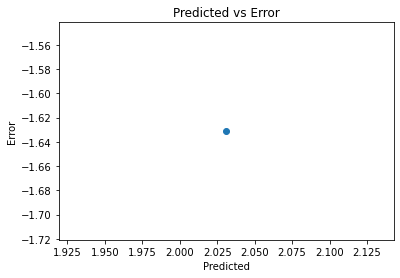

Median Absolute Error: nan
Mean Absolute Error: 1.6311367113470174
Mean Squared Error: 2.660606971103963
Root Mean Squared Error: 1.6311367113470174


In [123]:
spatial_vine_copula.plot_result_statistics()